In [1]:
from pyspark import SparkConf, SparkContext
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pyspark.sql
import os
from pyspark.sql import SparkSession,DataFrame
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pyspark.sql.functions as F
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import countDistinct
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from sklearn.svm import SVR
import time

In [2]:
spark = SparkSession.builder.config("spark.driver.maxResultSize", "4G").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 18:19:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
folder = "/Users/atul/Downloads/airline delay analysis"

files = sorted(file for file in os.listdir(folder) if file != 'schema.json')

files

['.DS_Store',
 '2009.csv',
 '2010.csv',
 '2011.csv',
 '2012.csv',
 '2013.csv',
 '2014.csv',
 '2015.csv',
 '2016.csv',
 '2017.csv',
 '2018.csv']

In [4]:
start_time = time.time()
# file = "/Users/atul/Downloads/CS 559 - Recordings/merged_dataset.csv"
file = f'{folder}/{files[0]}'

schema_file_path = "/Users/atul/Downloads/airline delay analysis/schema.json"

# Read the schema from the file
with open(schema_file_path, "r") as schema_file:
    schema_data = json.load(schema_file)

# Convert the schema data to a StructType
fields = [StructField(field["name"], eval(field["type"]), field.get("nullable", True)) for field in schema_data["fields"]]
schema = StructType(fields)

df = spark.read.option("header", "true").csv(file,schema=schema)

In [5]:
for file in files[1:]:
    temp_df = spark.read.option("header","true").csv(f'{folder}/{file}',schema=schema)
    df = df.union(temp_df)
    
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 1.4293739795684814 seconds


In [6]:
destinations_by_carrier = df.groupBy("OP_CARRIER").agg(countDistinct("DEST").alias("NumDestinations"))

columns_to_remove = ['FL_DATE','Unnamed: 27','CANCELLATION_CODE','ORIGIN','DEST','OP_CARRIER_FL_NUM','CRS_DEP_TIME',
                    'DEP_TIME','WHEELS_OFF','WHEELS_ON','CRS_ARR_TIME','ARR_TIME']

columns_to_keep = [column for column in df.columns if column not in columns_to_remove]

    
# Convert the string date column to a DateType column
df = df.withColumn("FL_DATE", F.to_date("FL_DATE", "yyyy-MM-dd").cast(DateType()))

# Update the "YEAR" column with the extracted year values using select
df = df.withColumn("Year", F.year("FL_DATE"))

df = df[columns_to_keep]

In [7]:
df.show(5)

+----------+---------+--------+-------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|OP_CARRIER|DEP_DELAY|TAXI_OUT|TAXI_IN|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Year|
+----------+---------+--------+-------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+
|        XE|     -2.0|    18.0|    8.0|      4.0|      0.0|     0.0|            62.0|               68.0|    42.0|   199.0|         null|         null|     null|          null|               null|2009|
|        XE|     -1.0|    28.0|    4.0|     -8.0|      0.0|     0.0|            82.0|               75.0|    43.0|   213.0|         null|         null|     null|          null|               n

In [8]:
start_time = time.time()
print(df.count())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

61556964
Execution Time: 4.381960868835449 seconds


In [9]:
columns_to_keep

['OP_CARRIER',
 'DEP_DELAY',
 'TAXI_OUT',
 'TAXI_IN',
 'ARR_DELAY',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'Year']

In [10]:
def get_unique(df, column_name):
    return list(set(row[column_name] for row in df.select(column_name).distinct().collect()))

In [11]:
delays = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
years = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

columns_to_fill = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']

# airline_names = {
#     'G4': 'Allegiant Air',
#     'CO': 'Continental Airlines',
#     'WN': 'Southwest Airlines',
#     'EV': 'ExpressJet Airlines',
#     'VX': 'Virgin America',
#     'OO': 'SkyWest Airlines',
#     'YX': 'Republic Airways',
#     'HA': 'Hawaiian Airlines',
#     'UA': 'United Airlines',
#     'MQ': 'Envoy Air',
#     'OH': 'PSA Airlines',
#     'YV': 'Mesa Airlines',
#     'AA': 'American Airlines',
#     'F9': 'Frontier Airlines',
#     'US': 'US Airways',
#     'XE': 'ExpressJet Airlines (old)',
#     '9E': 'Endeavor Air',
#     'DL': 'Delta Air Lines',
#     'AS': 'Alaska Airlines',
#     'FL': 'AirTran Airways',
#     'NW': 'Northwest Airlines',
#     'B6': 'JetBlue Airways',
#     'NK': 'Spirit Airlines'
# }


## Creating the target variable

In [12]:
start_time = time.time()

def preprocessing(temp):
    # Replacing null values with 0.0
    for column in columns_to_fill:
        temp = temp.withColumn(column, F.when(F.col(column).isNull(), 0.0).otherwise(F.col(column)))
    
    temp = temp.na.drop()
    return temp

df = preprocessing(df)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 0.07542872428894043 seconds


In [13]:
def feature_engineering(temp):
    temp = temp.withColumn("TIME_DIFF", F.col("ACTUAL_ELAPSED_TIME") - F.col("CRS_ELAPSED_TIME"))
    temp = temp.withColumn("IS_DELAYED",F.expr("CASE WHEN ARR_DELAY > 0 THEN 1 ELSE 0 END"))
    temp = temp.withColumn("TOTAL_DELAY", sum(F.col(delay) for delay in delays))
    return temp
    
df = feature_engineering(df)

In [14]:
df.show(5)

+----------+---------+--------+-------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+---------+----------+-----------+
|OP_CARRIER|DEP_DELAY|TAXI_OUT|TAXI_IN|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Year|TIME_DIFF|IS_DELAYED|TOTAL_DELAY|
+----------+---------+--------+-------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+----+---------+----------+-----------+
|        XE|     -2.0|    18.0|    8.0|      4.0|      0.0|     0.0|            62.0|               68.0|    42.0|   199.0|          0.0|          0.0|      0.0|           0.0|                0.0|2009|      6.0|         1|        2.0|
|        XE|     -1.0|    28.0|    4.0|     -8.0|      0.0| 

## Visualizing

### Total flights by carrier (2009-2018)

In [15]:
start_time = time.time()

# Group by carrier and compute the count of flights
total_flights_by_carrier = df.groupBy("OP_CARRIER").count()

# Convert to Pandas DataFrame for plotting
total_flights_pandas = total_flights_by_carrier.toPandas()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 19.64242386817932 seconds


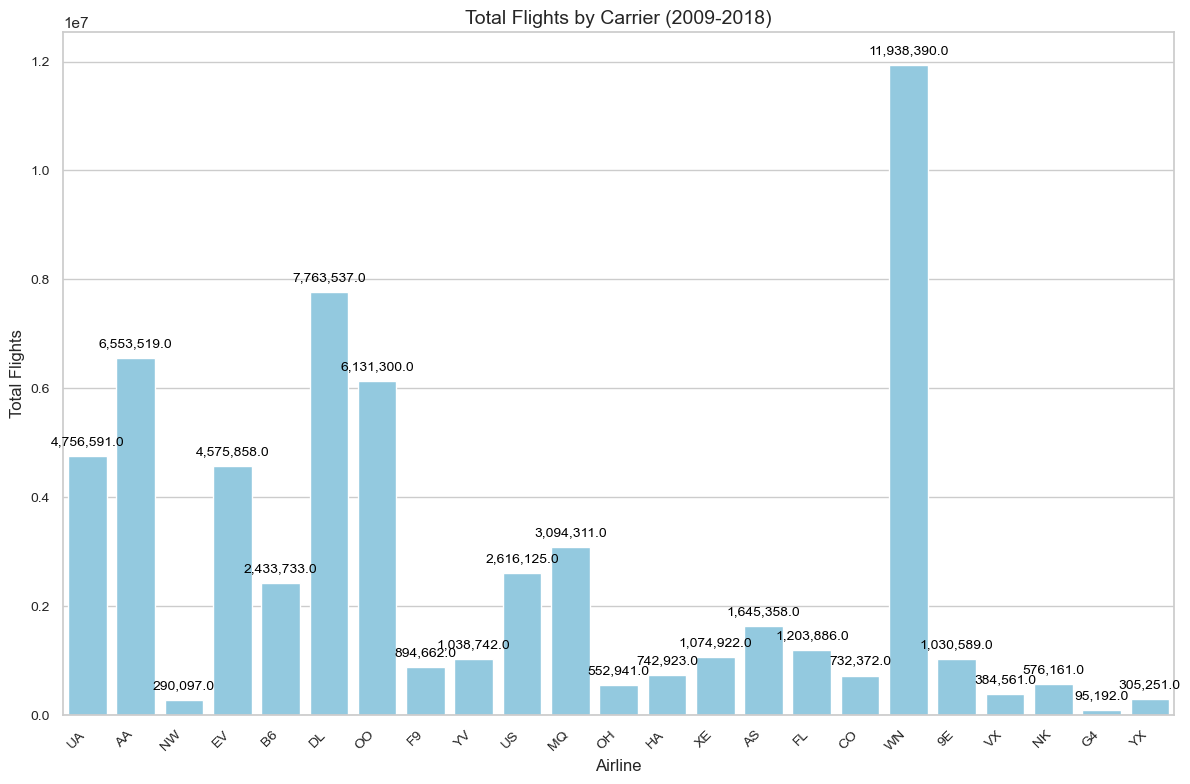

In [16]:
sns.set(style="whitegrid")

# Plot the data
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='OP_CARRIER', y='count', data=total_flights_pandas, color='skyblue')
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Total Flights', fontsize=12)
plt.title('Total Flights by Carrier (2009-2018)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Add value annotations on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), ','), 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10),
                     textcoords='offset points', fontsize=10, color='black')

plt.show()

In [17]:
# Calculate total delay for each carrier
carrier_total_delays = df.groupBy("OP_CARRIER").agg(F.sum("Total_Delay").alias("Total_Delay"))

# Convert the PySpark DataFrame to Pandas for plotting
# carrier_total_delays_pd = carrier_total_delays.toPandas()


carrier_air_time = df.groupBy("OP_CARRIER").agg(F.sum("ACTUAL_ELAPSED_TIME").alias("ACTUAL_ELAPSED_TIME"))
# carrier_air_time.toPandas()

# Merge the two DataFrames on the "OP_CARRIER" column
merged_df = carrier_total_delays.join(carrier_air_time, on="OP_CARRIER", how="inner")

# Calculate the ratio of Column1 to Column2
result_df = merged_df.withColumn("Ratio", F.col("Total_Delay") / F.col("ACTUAL_ELAPSED_TIME"))


airline_delay = result_df.toPandas()
airline_delay.head()

,OP_CARRIER,Total_Delay,ACTUAL_ELAPSED_TIME,Ratio
0,UA,124169567.0,8.824564e+08,0.140709
1,AA,173267079.0,1.087373e+09,0.159345
2,NW,5471205.0,4.308720e+07,0.126980
3,EV,161387533.0,4.334444e+08,0.372337
4,B6,87180092.0,4.106729e+08,0.212286


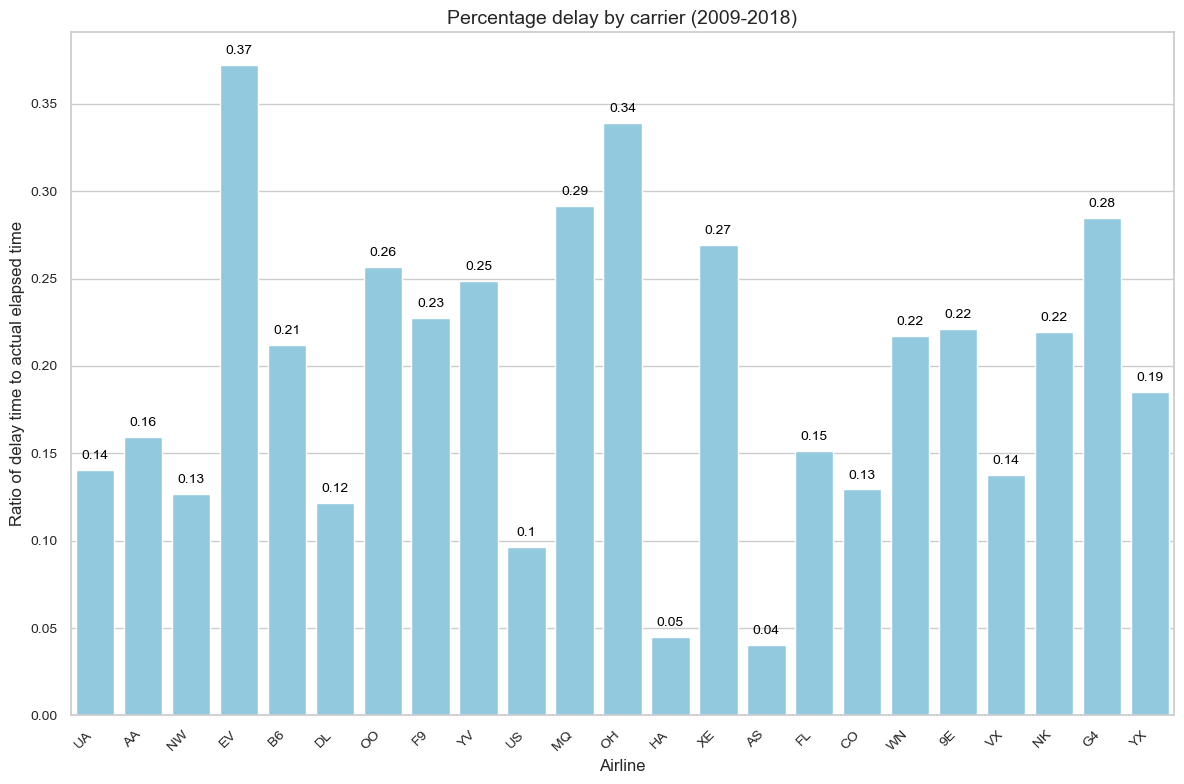

In [18]:
sns.set(style="whitegrid")
# Plot 'OP_CARRIER' vs. 'Ratio'
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='OP_CARRIER', y='Ratio', data=airline_delay, color='skyblue')
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Ratio of delay time to actual elapsed time', fontsize=12)
plt.title('Percentage delay by carrier (2009-2018)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Add value annotations on top of each bar
for p in barplot.patches:
    # Round off to 2 decimals
    annotation_text = format(round(p.get_height(), 2), ',')

    barplot.annotate(annotation_text,
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10),
                     textcoords='offset points', fontsize=10, color='black')

plt.show()

In [19]:
total_delayed_flights = df.groupBy("OP_CARRIER").agg(F.count("IS_DELAYED").alias("TOTAL_DELAYED_FLIGHTS"))
total_delayed_flights_pd = total_delayed_flights.toPandas()
destinations_by_carrier_pd = destinations_by_carrier.toPandas()
airline_delay = pd.merge(airline_delay, total_delayed_flights_pd, on="OP_CARRIER", how="left")
airline_delay = pd.merge(airline_delay, total_flights_pandas, on="OP_CARRIER", how="left")
airline_delay = pd.merge(airline_delay, destinations_by_carrier_pd, on="OP_CARRIER", how="left")
airline_delay.head()

,OP_CARRIER,Total_Delay,ACTUAL_ELAPSED_TIME,Ratio,TOTAL_DELAYED_FLIGHTS,count,NumDestinations
0,UA,124169567.0,8.824564e+08,0.140709,4756591,4756591,123
1,AA,173267079.0,1.087373e+09,0.159345,6553519,6553519,116
2,NW,5471205.0,4.308720e+07,0.126980,290097,290097,103
3,EV,161387533.0,4.334444e+08,0.372337,4575858,4575858,205
4,B6,87180092.0,4.106729e+08,0.212286,2433733,2433733,73


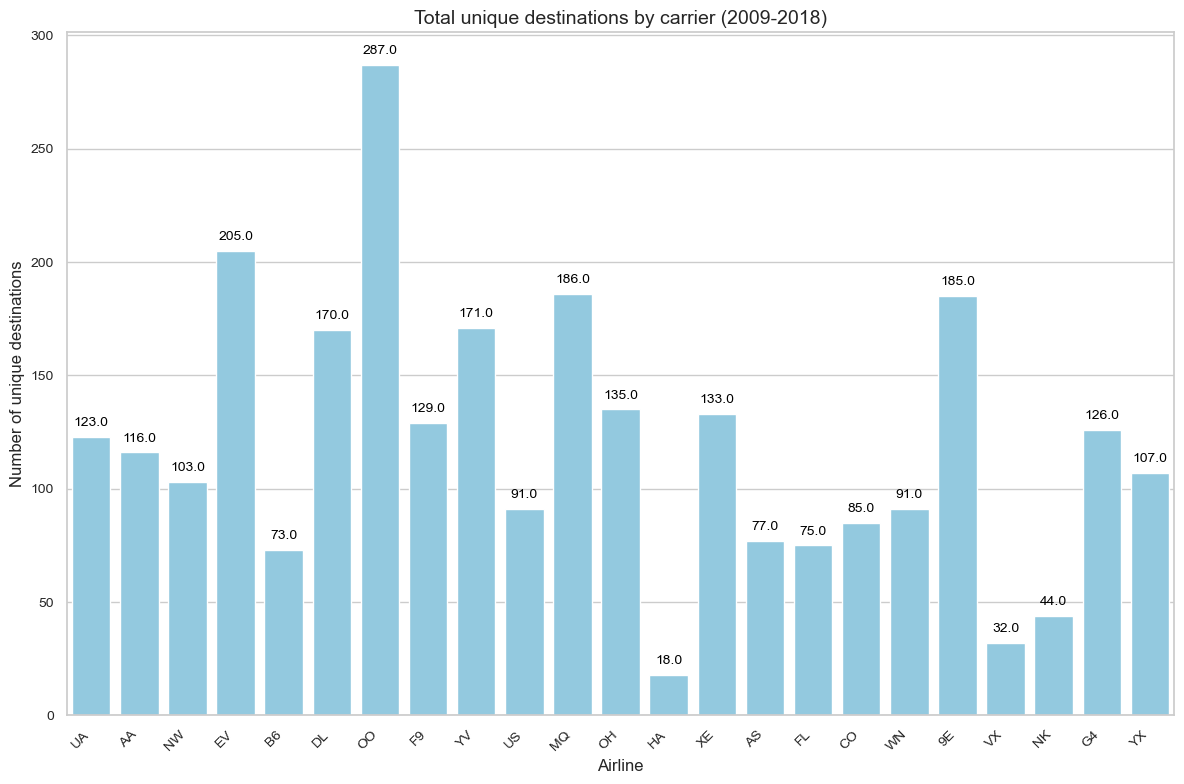

In [20]:
sns.set(style="whitegrid")
# Plot 'OP_CARRIER' vs. 'Number of destinations'
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='OP_CARRIER', y='NumDestinations', data=airline_delay, color='skyblue')
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Number of unique destinations', fontsize=12)
plt.title('Total unique destinations by carrier (2009-2018)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Add value annotations on top of each bar
for p in barplot.patches:
    # Round off to 2 decimals
    annotation_text = format(round(p.get_height(), 2), ',')

    barplot.annotate(annotation_text,
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10),
                     textcoords='offset points', fontsize=10, color='black')

plt.show()

## Modelling

In [21]:
columns_to_remove = ['OP_CARRIER','CANCELLED','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','CARRIER_DELAY',
                    'WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','Year','TIME_DELAYED','TOTAL_DELAY']

columns_to_keep = [column for column in df.columns if column not in columns_to_remove]

df = df[columns_to_keep]


In [22]:
df.show()

+---------+--------+-------+---------+--------+--------+---------+----------+
|DEP_DELAY|TAXI_OUT|TAXI_IN|ARR_DELAY|DIVERTED|DISTANCE|TIME_DIFF|IS_DELAYED|
+---------+--------+-------+---------+--------+--------+---------+----------+
|     -2.0|    18.0|    8.0|      4.0|     0.0|   199.0|      6.0|         1|
|     -1.0|    28.0|    4.0|     -8.0|     0.0|   213.0|     -7.0|         0|
|     -1.0|    20.0|    6.0|     -9.0|     0.0|   199.0|     -8.0|         0|
|      9.0|    10.0|    9.0|    -12.0|     0.0|   199.0|    -21.0|         0|
|    -10.0|    24.0|   13.0|    -38.0|     0.0|   213.0|    -28.0|         0|
|     -2.0|    19.0|   15.0|    -19.0|     0.0|   745.0|    -17.0|         0|
|     -8.0|    12.0|    5.0|    -17.0|     0.0|   554.0|     -9.0|         0|
|     -7.0|     9.0|   34.0|     -8.0|     0.0|   199.0|     -1.0|         0|
|     -5.0|    28.0|    4.0|    -15.0|     0.0|   199.0|    -10.0|         0|
|     -5.0|    15.0|    7.0|    -12.0|     0.0|   199.0|     -7.

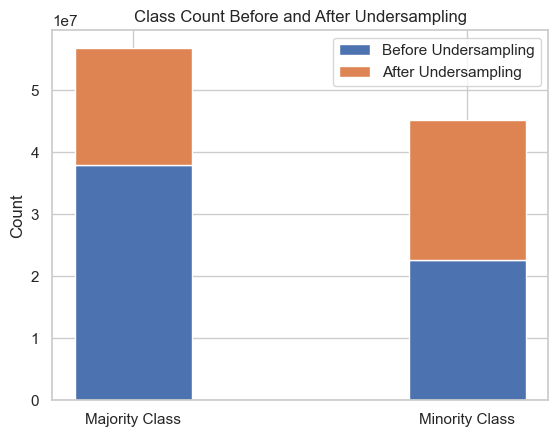

In [23]:
# Determine class distribution before undersampling
class_distribution_before = df.groupBy("IS_DELAYED").count().toPandas()

# Find the majority class
majority_class = class_distribution_before.sort_values(by="count", ascending=False).iloc[0]["IS_DELAYED"]

# Separate majority and minority classes before undersampling
majority_class_count_before = class_distribution_before[class_distribution_before["IS_DELAYED"] == majority_class]["count"].values[0]
minority_class_count_before = class_distribution_before[class_distribution_before["IS_DELAYED"] != majority_class]["count"].values[0]

# Undersample majority class
undersampled_majority = df.filter(F.col("IS_DELAYED") == majority_class).sample(withReplacement=False, fraction=0.5, seed=42)
df = undersampled_majority.union(df.filter(F.col("IS_DELAYED") != majority_class))

# Determine class distribution after undersampling
class_distribution_after = df.groupBy("IS_DELAYED").count().toPandas()

# Separate majority and minority classes after undersampling
majority_class_count_after = class_distribution_after[class_distribution_after["IS_DELAYED"] == majority_class]["count"].values[0]
minority_class_count_after = class_distribution_after[class_distribution_after["IS_DELAYED"] != majority_class]["count"].values[0]

# Plot class count before and after undersampling
labels = ["Majority Class", "Minority Class"]
counts_before = [majority_class_count_before, minority_class_count_before]
counts_after = [majority_class_count_after, minority_class_count_after]

fig, ax = plt.subplots()
width = 0.35

ax.bar(labels, counts_before, width, label='Before Undersampling')
ax.bar(labels, counts_after, width, bottom=counts_before, label='After Undersampling')

ax.set_ylabel('Count')
ax.set_title('Class Count Before and After Undersampling')
ax.legend()

plt.show()


In [24]:
start_time = time.time()

# Create a sample of 100k rows
sampled_df = df.sample(withReplacement=False, fraction=0.01, seed=42)

# Convert the sample to Pandas DataFrame
df_pandas = sampled_df.toPandas()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time to sample larger df: {execution_time} seconds")

Execution Time to sample larger df: 38.864728927612305 seconds


In [25]:
start_time = time.time()

# Create a sample of 100k rows
sampled_df_small = df.sample(withReplacement=False, fraction=0.001, seed=42)

# Convert the sample to Pandas DataFrame
df_pandas_small = sampled_df_small.toPandas()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time to sample smaller df: {execution_time} seconds")

Execution Time to sample smaller df: 37.77227711677551 seconds


In [26]:
df_pandas.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,DIVERTED,DISTANCE,TIME_DIFF,IS_DELAYED
0,3.0,11.0,6.0,-9.0,0.0,657.0,-12.0,0
1,-10.0,10.0,17.0,-8.0,0.0,1033.0,2.0,0
2,-10.0,5.0,4.0,-15.0,0.0,100.0,-5.0,0
3,-6.0,10.0,7.0,-9.0,0.0,589.0,-3.0,0
4,-3.0,11.0,4.0,-16.0,0.0,846.0,-13.0,0


In [27]:
df_pandas.shape

(415044, 8)

In [28]:
target = 'IS_DELAYED'
features = ['DEP_DELAY','TAXI_OUT','TAXI_IN','DISTANCE']
X = df_pandas[features]
y = df_pandas[target]

In [29]:
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [31]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

## Logistic Regression

Accuracy: 0.8305966822874628
Precision: 0.8727775108121095
Recall: 0.805575268340282
F1 Score: 0.8378309807177784
Execution Time: 0.2603483200073242 seconds


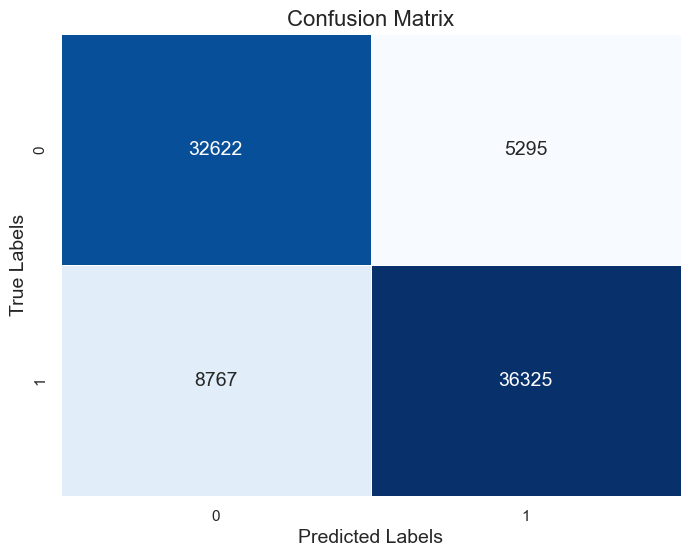

In [32]:
start_time = time.time()

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy_scores.append(accuracy)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## XGBoost

Accuracy: 0.836294859593538
Precision: 0.8702315195675168
Recall: 0.8210769094296105
F1 Score: 0.8449399226354165
Execution Time: 3.4164011478424072 seconds


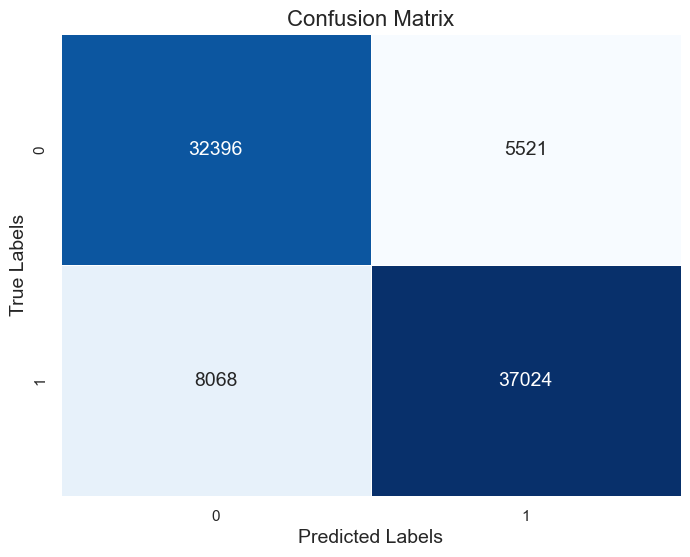

In [33]:
start_time = time.time()

# XGBoost
model = XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy_scores.append(accuracy)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

# Plot the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Random Forest

Accuracy: 0.7970099627751208
Precision: 0.811186037286791
Recall: 0.8163310565066975
F1 Score: 0.813750414502045
Execution Time: 32.25837016105652 seconds


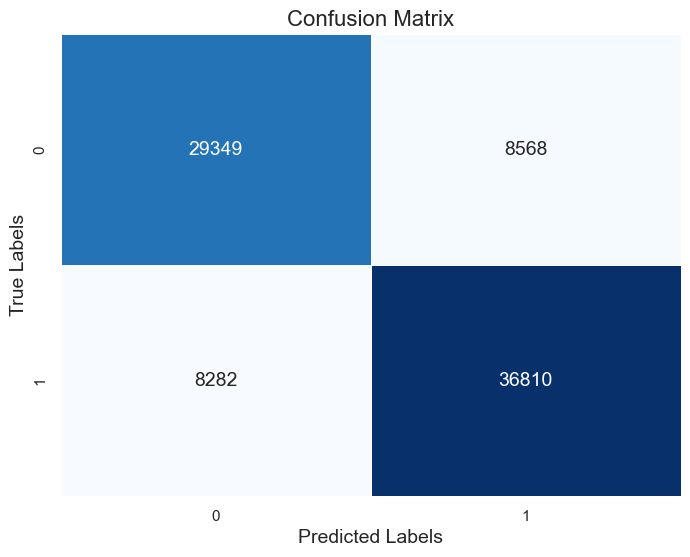

In [34]:
start_time = time.time()

# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy_scores.append(accuracy)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

# Plot the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Bagging Classifier

Accuracy: 0.7970099627751208
Precision: 0.811186037286791
Recall: 0.8163310565066975
F1 Score: 0.813750414502045
Execution Time: 26.787117958068848 seconds


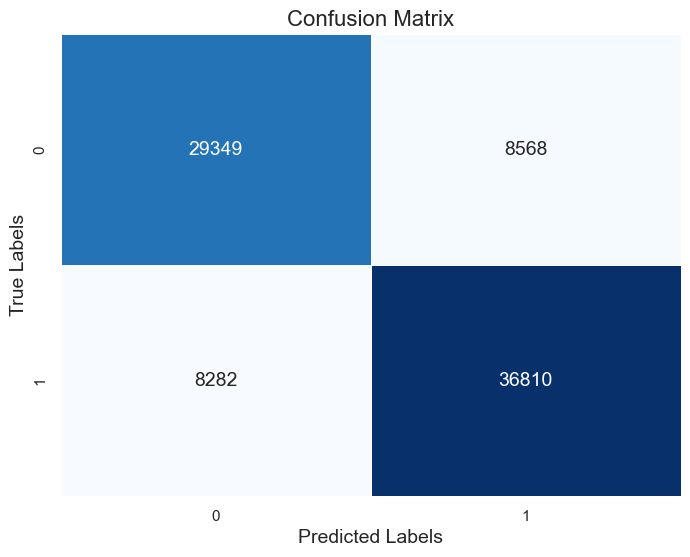

In [35]:
start_time = time.time()

# Bagging Classifier
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                          n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred_bagging = model.predict(X_test)
# Calculate and print various evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy_scores.append(accuracy)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

# Plot the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

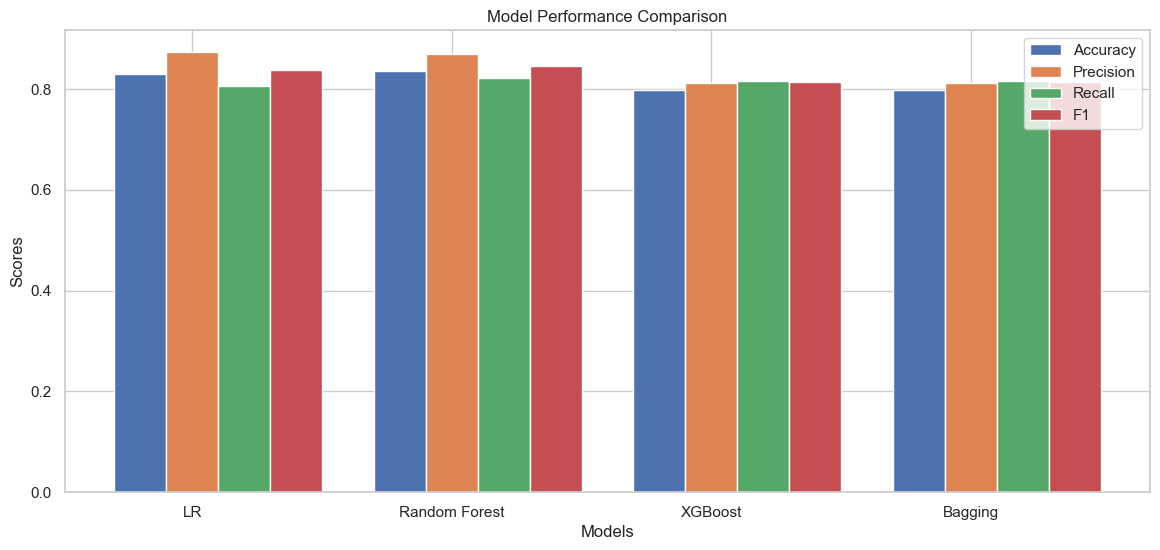

In [36]:
model_names = ['LR', 'Random Forest', 'XGBoost','Bagging']

# Number of models
num_models = len(model_names)


fig, ax = plt.subplots(figsize=(14, 6))

# Bar width
bar_width = 0.2
bar_positions = np.arange(num_models)

# Plot bars for each metric
plt.bar(bar_positions - bar_width, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(bar_positions, precision_scores, width=bar_width, label='Precision')
plt.bar(bar_positions + bar_width, recall_scores, width=bar_width, label='Recall')
plt.bar(bar_positions + 2 * bar_width, f1_scores, width=bar_width, label='F1')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(bar_positions, model_names)
plt.legend()

# Show the plot
plt.show()